# Calculating fisher score in the training of the CNN

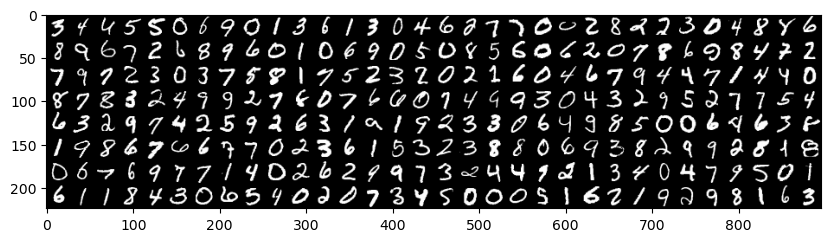

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets

datadir = "./data"
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(datadir, download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_set = datasets.MNIST(datadir, train=False, download=True, transform=transform)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

tmp_loader = DataLoader(val_set, batch_size=3000, shuffle=True)
X_display, y_display = val_loader.__iter__().next()

X, y = train_loader.__iter__().next()
out = X.detach().numpy()
out = out.reshape(8, int(batch_size / 8),28,28)
out = out.transpose(0,2,1,3)
out = out.reshape(8*28,int(batch_size / 8)*28)
out = (out*(batch_size - 1)).astype(np.uint8)

plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(out, "gray")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f

class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv2d(1,16,3,1)
        self.conv2 = nn.Conv2d(16,16,3,1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.dim_feature = 128
        self.fc1 = nn.Linear(12*12*16, self.dim_feature)
        self.fc2 = nn.Linear(self.dim_feature, 10)
        
        self._last_feature = None

    def forward(self,x):
        x = self.conv1(x)
        x = f.relu(x)
        x = self.conv2(x)
        x = f.relu(x)
        x = self.pool(x)
        x = x.view(-1, 12*12*16)
        x = self.fc1(x)
        x = torch.tanh(x)
                
        self._last_feature = x.detach()
        
        x = self.fc2(x)

        return f.log_softmax(x, dim=1)
    
    @property
    def last_feature(self):
        return self._last_feature.detach()
    
net = CNNmodel()
print(net)

CNNmodel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
#エポック数，バッジサイズ
epoch = 300

#学習結果の保存
history = {
    "train_loss": [],
    "validation_loss": [],
    "validation_acc": [],
    "fisher_score": [],
    "tr_b": [],
    "tr_w": [],
}

data_loader = {"train":train_loader, "validation":val_loader}

#GPUが使えるときは使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Fisher descriminant ratio

def fisher_descriminant_score():
    net.eval()
    
    n_class = len(set(val_set.targets.numpy()))
    n_for_each_class = {i: 0 for i in range(n_class)}

    mean_global = np.zeros(net.dim_feature)
    mean_c = np.zeros((n_class, net.dim_feature))
    
    s_c = np.zeros((n_class, net.dim_feature, net.dim_feature))
    s_W = np.zeros((net.dim_feature, net.dim_feature))
    s_B = np.zeros((net.dim_feature, net.dim_feature))

    with torch.no_grad():
        # Calculate global mean
        for data, target in data_loader["validation"]:
            data, target = data.to(device), target.to(device)

            #順伝搬の計算
            net(data)

            x = net.last_feature.numpy()

            for i in range(len(data)):
                mean_global += x[i]

                c = int(target.numpy()[i])
                x_c = x[i]

                mean_c[c] += x_c
                n_for_each_class[c] += 1        
                
    # get global mean
    n_all = np.sum(list(n_for_each_class.values()))
    mean_global /= n_all
        
    # get class mean
    for c in range(n_class):
        mean_c[c] /= n_for_each_class[c]

    # within-class scatter
    with torch.no_grad():
        for data, target in data_loader["validation"]:
            data, target = data.to(device), target.to(device)

            net(data)

            for i in range(len(data)):
                c = int(target[i].numpy())
                x_hat_c = net.last_feature[i].numpy()
                mu = np.atleast_2d(x_hat_c - mean_c[c])
                s = np.dot(mu, mu.transpose())
                s_c[c] += s

    s_W = np.sum(s_c, axis=0)

    # between-class scatter
    for c in range(n_class):
        mu = np.atleast_2d(mean_c[c] - mean_global)
        s = n_for_each_class[c] * np.dot(mu, mu.transpose())
        s_B += s

    # Fisher descriminant ratio-based score
    fisher_disc_ratio = np.dot(np.linalg.pinv(s_W), s_B)
    score = np.trace(fisher_disc_ratio)
        
    return score, np.trace(s_B), np.trace(s_W)

print("example (score, between_class_cov_tr, within_class_cov_tr): ", fisher_descriminant_score())

example (score, between_class_cov_tr, within_class_cov_tr):  (0.36086429870872594, 33653.564576339966, 93258.22669840699)


In [9]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# embed = LinearDiscriminantAnalysis(n_components=2)

from sklearn.manifold import TSNE
embed = TSNE(n_components=2, init="pca", random_state=0)

fig = plt.figure(figsize=(5, 5), dpi=100)

#ネットワーク構造の構築
net = CNNmodel().to(device)
print(net)

#最適化方法の設定
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

for e in range(epoch):
    print("\nValidation start:")
    net.eval() #検証モード(Validation)
    val_loss = 0.0
    accuracy = 0.0

    with torch.no_grad():
        for data,target in data_loader["validation"]:
            data,target = data.to(device),target.to(device)

            #順伝搬の計算
            output = net(data)
            loss = f.nll_loss(output,target).item()
            val_loss += f.nll_loss(output,target,reduction='sum').item()
            predict = output.argmax(dim=1,keepdim=True)
            accuracy += predict.eq(target.view_as(predict)).sum().item()

    val_loss /= len(data_loader["validation"].dataset)
    accuracy /= len(data_loader["validation"].dataset)

    print("Validation loss: {}, Accuracy: {}\n".format(val_loss,accuracy))
    history["validation_loss"].append(val_loss)
    history["validation_acc"].append(accuracy)
    
    # Fisher discriminant measure の計算：Zarka et al. 2020
    print("Fisher discrinimant measure start:")
    score, tr_b, tr_w = fisher_descriminant_score()
    history["fisher_score"].append(score)
    history["tr_w"].append(tr_w)
    history["tr_b"].append(tr_b)
    print(f"Fisher desctiminant score: {score}")
    print(f"within-class cov: {tr_w}, between-class cov: {tr_b}")
    
    # LDA projection
    net(X_display)

    x = net.last_feature.numpy()
    
    if isinstance(embed, LinearDiscriminantAnalysis):
        X_r = embed.fit(x, y_display).transform(x)
    elif isinstance(embed, TSNE):
        X_r = embed.fit_transform(x)
    
    cmap = plt.get_cmap("tab10")
    
    for i in range(10):
        plt.scatter(
            X_r[y_display == i, 0], X_r[y_display == i, 1], alpha=0.5, color=cmap(i), label=i
        )
    plt.legend([str(i) for i in range(10)], loc='upper right')
    plt.xlim([-20, 20])
    plt.ylim([-20, 20])
    fig.savefig(f"img_tsne_{e}.png")
    plt.axis("off")
    plt.clf()
    
    """ 学習部分 """
    loss = None
    train_loss = 0.0
    net.train() #学習モード
    print("\nTrain start")
    for i, (data, target) in enumerate(data_loader["train"]):
        data, target = data.to(device), target.to(device)
        
        #勾配の初期化
        optimizer.zero_grad()

        output = net(data)
        loss = f.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 5 == 4:
            print("Training: {} epoch. {} iteration. Loss:{}".format(e+1,i+1,loss.item()))
            break

    train_loss /= len(data_loader["train"])
    print("Training loss (ave.): {}".format(train_loss))
    history["train_loss"].append(train_loss)
    
    print("---")
    

CNNmodel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Validation start:
Validation loss: 2.3039051902770997, Accuracy: 0.0897

Fisher discrinimant measure start:
Fisher desctiminant score: 0.2574233559069362
within-class cov: 36908.297082497455, between-class cov: 9501.05769578667

Train start
Training: 1 epoch. 5 iteration. Loss:2.225916862487793
Training loss (ave.): 0.04822746743547156
---

Validation start:
Validation loss: 2.164665774536133, Accuracy: 0.4089

Fisher discrinimant measure start:
Fisher desctiminant score: 1.1965719115740492
within-class cov: 152808.28941158432, between-class cov: 182846.10696557985

Train start
Training: 2 epoch. 5 iteration. Loss:1.9326894283294678
Training loss (a

Training: 23 epoch. 5 iteration. Loss:0.20455612242221832
Training loss (ave.): 0.004872324428659805
---

Validation start:
Validation loss: 0.20486116424798964, Accuracy: 0.9391

Fisher discrinimant measure start:
Fisher desctiminant score: 1.9137997150396302
within-class cov: 35235697.29274196, between-class cov: 67434067.43807222

Train start
Training: 24 epoch. 5 iteration. Loss:0.21726912260055542
Training loss (ave.): 0.004974492560041711
---

Validation start:
Validation loss: 0.20320233979225158, Accuracy: 0.9388

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8709441218819693
within-class cov: 35616705.931674175, between-class cov: 66636866.603664644

Train start
Training: 25 epoch. 5 iteration. Loss:0.188432514667511
Training loss (ave.): 0.003911267823361336
---

Validation start:
Validation loss: 0.19524191312789918, Accuracy: 0.9443

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8965691833981357
within-class cov: 35050611.23087424, betwee

Fisher desctiminant score: 2.120883648109724
within-class cov: 33893543.9626746, between-class cov: 71884263.16692437

Train start
Training: 47 epoch. 5 iteration. Loss:0.10274959355592728
Training loss (ave.): 0.002054305628259131
---

Validation start:
Validation loss: 0.09577872858047486, Accuracy: 0.9714

Fisher discrinimant measure start:
Fisher desctiminant score: 2.1685478634907795
within-class cov: 33545031.924895827, between-class cov: 72744007.31146297

Train start
Training: 48 epoch. 5 iteration. Loss:0.10696937888860703
Training loss (ave.): 0.002063286082541689
---

Validation start:
Validation loss: 0.09858579952120781, Accuracy: 0.9697

Fisher discrinimant measure start:
Fisher desctiminant score: 2.174957629394524
within-class cov: 33502580.97011638, between-class cov: 72866694.08536242

Train start
Training: 49 epoch. 5 iteration. Loss:0.10429853200912476
Training loss (ave.): 0.0018779850386558695
---

Validation start:
Validation loss: 0.09236010714173316, Accuracy: 

Validation loss: 0.0719456983268261, Accuracy: 0.979

Fisher discrinimant measure start:
Fisher desctiminant score: 2.2059630658657525
within-class cov: 32645474.718193233, between-class cov: 72014711.49598847

Train start
Training: 71 epoch. 5 iteration. Loss:0.05511394143104553
Training loss (ave.): 0.0013824927997081837
---

Validation start:
Validation loss: 0.07137893469929694, Accuracy: 0.9782

Fisher discrinimant measure start:
Fisher desctiminant score: 2.210798827215494
within-class cov: 33588673.73250716, between-class cov: 74257800.49555084

Train start
Training: 72 epoch. 5 iteration. Loss:0.09534048289060593
Training loss (ave.): 0.0012911624889424508
---

Validation start:
Validation loss: 0.0729356102347374, Accuracy: 0.9777

Fisher discrinimant measure start:
Fisher desctiminant score: 2.2027553080543174
within-class cov: 33696193.905930944, between-class cov: 74224469.98751678

Train start
Training: 73 epoch. 5 iteration. Loss:0.05854026600718498
Training loss (ave.): 


Train start
Training: 94 epoch. 5 iteration. Loss:0.07335614413022995
Training loss (ave.): 0.0015300409036113861
---

Validation start:
Validation loss: 0.05489554273486137, Accuracy: 0.9831

Fisher discrinimant measure start:
Fisher desctiminant score: 2.1845326399828755
within-class cov: 34199519.61205078, between-class cov: 74709966.86425933

Train start
Training: 95 epoch. 5 iteration. Loss:0.05422649160027504
Training loss (ave.): 0.0011445423865571935
---

Validation start:
Validation loss: 0.05395132023543119, Accuracy: 0.9824

Fisher discrinimant measure start:
Fisher desctiminant score: 2.2113301721703715
within-class cov: 33926150.80983879, between-class cov: 75021920.9113989

Train start
Training: 96 epoch. 5 iteration. Loss:0.05241789668798447
Training loss (ave.): 0.0013775245940431636
---

Validation start:
Validation loss: 0.056829268680512905, Accuracy: 0.9807

Fisher discrinimant measure start:
Fisher desctiminant score: 2.2070303652583343
within-class cov: 34144343.

Fisher desctiminant score: 2.161968718108028
within-class cov: 35300709.44386201, between-class cov: 76319029.54465032

Train start
Training: 118 epoch. 5 iteration. Loss:0.0488041490316391
Training loss (ave.): 0.0009019975491026614
---

Validation start:
Validation loss: 0.047524833393096926, Accuracy: 0.9837

Fisher discrinimant measure start:
Fisher desctiminant score: 2.154943018617934
within-class cov: 35173479.272658534, between-class cov: 75796843.59911826

Train start
Training: 119 epoch. 5 iteration. Loss:0.06849004328250885
Training loss (ave.): 0.001045521412124025
---

Validation start:
Validation loss: 0.04656036158800125, Accuracy: 0.9846

Fisher discrinimant measure start:
Fisher desctiminant score: 2.1657924084074693
within-class cov: 34858547.60598033, between-class cov: 75496377.7731426

Train start
Training: 120 epoch. 5 iteration. Loss:0.03389473631978035
Training loss (ave.): 0.0009599127985061483
---

Validation start:
Validation loss: 0.046400666177272794, Accur

Validation loss: 0.05054463099837303, Accuracy: 0.9841

Fisher discrinimant measure start:
Fisher desctiminant score: 2.0283892293026033
within-class cov: 37590017.24225898, between-class cov: 76247186.10349716

Train start
Training: 142 epoch. 5 iteration. Loss:0.04798700287938118
Training loss (ave.): 0.0010290668682849155
---

Validation start:
Validation loss: 0.042744494327902796, Accuracy: 0.9859

Fisher discrinimant measure start:
Fisher desctiminant score: 2.0678614838465146
within-class cov: 36732569.66892408, between-class cov: 75957866.02107693

Train start
Training: 143 epoch. 5 iteration. Loss:0.048849206417798996
Training loss (ave.): 0.0007987224833762392
---

Validation start:
Validation loss: 0.043190854644775394, Accuracy: 0.986

Fisher discrinimant measure start:
Fisher desctiminant score: 2.0502233982912443
within-class cov: 36791151.50918155, between-class cov: 75430079.674202

Train start
Training: 144 epoch. 5 iteration. Loss:0.04263687878847122
Training loss (av


Train start
Training: 165 epoch. 5 iteration. Loss:0.05340713635087013
Training loss (ave.): 0.0008684898072734793
---

Validation start:
Validation loss: 0.04132193633057177, Accuracy: 0.986

Fisher discrinimant measure start:
Fisher desctiminant score: 2.084886115671857
within-class cov: 37001382.38833271, between-class cov: 77143668.40210018

Train start
Training: 166 epoch. 5 iteration. Loss:0.06587649881839752
Training loss (ave.): 0.0007367018610239029
---

Validation start:
Validation loss: 0.04078044443279505, Accuracy: 0.9862

Fisher discrinimant measure start:
Fisher desctiminant score: 2.0792898786477068
within-class cov: 37142398.837710604, between-class cov: 77229813.97194818

Train start
Training: 167 epoch. 5 iteration. Loss:0.01903950423002243
Training loss (ave.): 0.00048297357527499505
---

Validation start:
Validation loss: 0.047089107513427736, Accuracy: 0.9852

Fisher discrinimant measure start:
Fisher desctiminant score: 2.070131759326052
within-class cov: 377123

Validation loss: 0.03932245261669159, Accuracy: 0.9875

Fisher discrinimant measure start:
Fisher desctiminant score: 2.019811069270112
within-class cov: 38027533.19855767, between-class cov: 76808432.49148366

Train start
Training: 189 epoch. 5 iteration. Loss:0.01268419623374939
Training loss (ave.): 0.0004226512374713066
---

Validation start:
Validation loss: 0.03910149502679706, Accuracy: 0.9879

Fisher discrinimant measure start:
Fisher desctiminant score: 2.0007919106477408
within-class cov: 38517549.282590315, between-class cov: 77065601.02258252

Train start
Training: 190 epoch. 5 iteration. Loss:0.011834118515253067
Training loss (ave.): 0.0007390945594995579
---

Validation start:
Validation loss: 0.039904631567001345, Accuracy: 0.9869

Fisher discrinimant measure start:
Fisher desctiminant score: 1.9880714059464493
within-class cov: 38737231.73739199, between-class cov: 77012382.76263049

Train start
Training: 191 epoch. 5 iteration. Loss:0.021109644323587418
Training loss 


Train start
Training: 212 epoch. 5 iteration. Loss:0.05396965518593788
Training loss (ave.): 0.000566087877179714
---

Validation start:
Validation loss: 0.03645560345351696, Accuracy: 0.9881

Fisher discrinimant measure start:
Fisher desctiminant score: 1.9649203257829981
within-class cov: 39101719.68796913, between-class cov: 76831763.78795981

Train start
Training: 213 epoch. 5 iteration. Loss:0.014948109164834023
Training loss (ave.): 0.0004988723454323221
---

Validation start:
Validation loss: 0.03662621441334486, Accuracy: 0.9874

Fisher discrinimant measure start:
Fisher desctiminant score: 1.9429113179369817
within-class cov: 38784271.949974425, between-class cov: 75354400.92955092

Train start
Training: 214 epoch. 5 iteration. Loss:0.005885481368750334
Training loss (ave.): 0.0003551489197985923
---

Validation start:
Validation loss: 0.03518539468944073, Accuracy: 0.988

Fisher discrinimant measure start:
Fisher desctiminant score: 1.9670087346399046
within-class cov: 39063

Validation loss: 0.03898014034666121, Accuracy: 0.9873

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8758315772732326
within-class cov: 40170817.11933275, between-class cov: 75353687.2373127

Train start
Training: 236 epoch. 5 iteration. Loss:0.02477479726076126
Training loss (ave.): 0.0005133318259043896
---

Validation start:
Validation loss: 0.03841033687070012, Accuracy: 0.9883

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8748484011927076
within-class cov: 40198724.06873323, between-class cov: 75366513.55025126

Train start
Training: 237 epoch. 5 iteration. Loss:0.009641899727284908
Training loss (ave.): 0.0004203041381341346
---

Validation start:
Validation loss: 0.03858899746937677, Accuracy: 0.9877

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8713572456669914
within-class cov: 40835934.38024278, between-class cov: 76418621.68604921

Train start
Training: 238 epoch. 5 iteration. Loss:0.013020466081798077
Training loss (a


Train start
Training: 259 epoch. 5 iteration. Loss:0.01809297502040863
Training loss (ave.): 0.00048268945055439117
---

Validation start:
Validation loss: 0.035054985545948145, Accuracy: 0.9884

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8907074441515515
within-class cov: 41075177.97082062, between-class cov: 77661144.75928

Train start
Training: 260 epoch. 5 iteration. Loss:0.0064599765464663506
Training loss (ave.): 0.0005473945012435
---

Validation start:
Validation loss: 0.03684919760227203, Accuracy: 0.9882

Fisher discrinimant measure start:
Fisher desctiminant score: 1.866124680502217
within-class cov: 40955249.6132083, between-class cov: 76427602.09933674

Train start
Training: 261 epoch. 5 iteration. Loss:0.023387828841805458
Training loss (ave.): 0.0003921961134418528
---

Validation start:
Validation loss: 0.03848240567073226, Accuracy: 0.9878

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8591983927284519
within-class cov: 40999089.

Validation loss: 0.03647440540539101, Accuracy: 0.9875

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8223187740142348
within-class cov: 42398657.650490046, between-class cov: 77263869.8294902

Train start
Training: 283 epoch. 5 iteration. Loss:0.01473958883434534
Training loss (ave.): 0.0002341984156915482
---

Validation start:
Validation loss: 0.03550811338424682, Accuracy: 0.988

Fisher discrinimant measure start:
Fisher desctiminant score: 1.8276236610751084
within-class cov: 42383227.88593494, between-class cov: 77460590.11707315

Train start
Training: 284 epoch. 5 iteration. Loss:0.016103530302643776
Training loss (ave.): 0.00040163540261540007
---

Validation start:
Validation loss: 0.03606141458339989, Accuracy: 0.9865

Fisher discrinimant measure start:
Fisher desctiminant score: 1.830611608408332
within-class cov: 42617055.095421314, between-class cov: 78015275.77385546

Train start
Training: 285 epoch. 5 iteration. Loss:0.02800806425511837
Training loss (a

<Figure size 500x500 with 0 Axes>

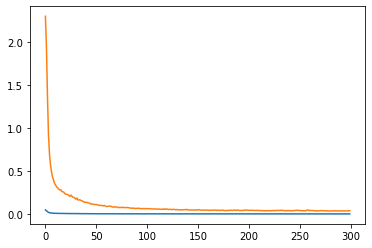

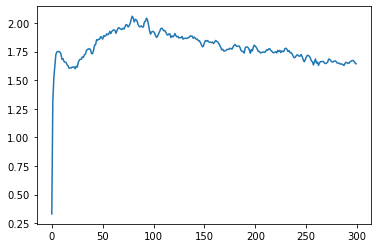

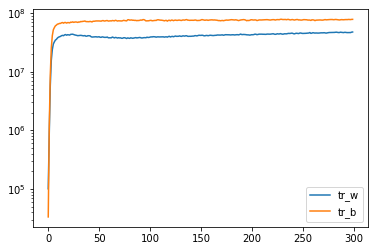

In [11]:
plt.plot(history["train_loss"][:epoch])
plt.plot(history["validation_loss"][:epoch])
plt.show()
plt.plot(history["fisher_score"][:epoch])
plt.show()
plt.plot(history["tr_w"][:epoch])
plt.plot(history["tr_b"][:epoch])
plt.legend(["tr_w", "tr_b"][:epoch])
plt.yscale("log")